In [1]:
import numpy as np

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
data = pd.read_csv('online_retail.csv')

In [7]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [11]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [14]:
from datetime import datetime

In [17]:
data.loc[:,'InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392693 entries, 0 to InvoiceDate
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  object        
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  object        
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 27.0+ MB


In [35]:
#feature engineering
data.loc[:,'TotalAmount'] = data['Quantity'] * data['UnitPrice']

# Calculate Recency, Frequency, and Monetary Value for each customer

# Reference date (could be the latest date in the dataset)
reference_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency: Number of days since last purchase
recency = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days})
recency.columns = ['Recency']

# Frequency: Number of purchases
frequency = data.groupby('CustomerID').agg({'InvoiceNo': 'nunique'})
frequency.columns = ['Frequency']

# Monetary: Total amount spent
monetary = data.groupby('CustomerID').agg({'TotalAmount': 'sum'})
monetary.columns = ['Monetary']

# Combine the features into a single DataFrame
rfm = recency.merge(frequency, left_index=True, right_index=True).merge(monetary, left_index=True, right_index=True)

print(rfm.head())


            Recency  Frequency Monetary
CustomerID                             
12346.0         326          1  77183.6
12347.0           2          7   4310.0
12348.0          75          4  1797.24
12349.0          19          1  1757.55
12350.0         310          1    334.4


In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
rfm_scaled = scaler.fit_transform(rfm)

print(rfm_scaled[:5])  # Check the scaled data

[[ 2.33457414 -0.4250965   8.36301037]
 [-0.90534032  0.3544168   0.2516989 ]
 [-0.17535959 -0.03533985 -0.02798783]
 [-0.73534481 -0.4250965  -0.03240559]
 [ 2.17457836 -0.4250965  -0.19081155]]


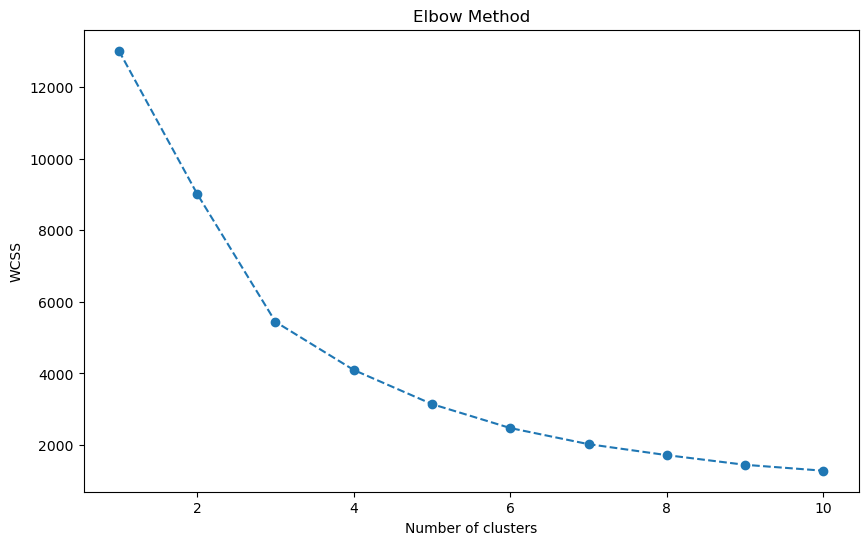

In [36]:
# Finding the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i,n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()





In [37]:
# Apply K-Means with the optimal number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters,n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())

            Recency  Frequency Monetary  Cluster
CustomerID                                      
12346.0         326          1  77183.6        1
12347.0           2          7   4310.0        3
12348.0          75          4  1797.24        3
12349.0          19          1  1757.55        3
12350.0         310          1    334.4        0


            Recency  Frequency       Monetary
Cluster                                      
0        248.564030   1.551789     476.330547
1         15.672986  22.047393   12435.086682
2          7.384615  82.538462  127187.959231
3         43.920380   3.656291    1344.724473


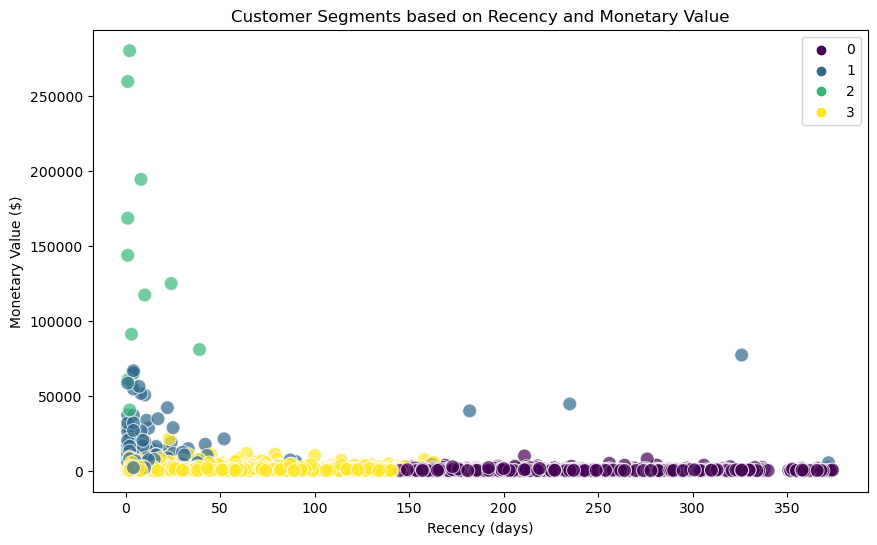

In [29]:
# Analyze the characteristics of each cluster
rfm_cluster_analysis = rfm.groupby('Cluster').mean()
print(rfm_cluster_analysis)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments based on Recency and Monetary Value')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value ($)')
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f'Silhouette Score: {score}')


Silhouette Score: 0.6160407381533093
